In [1]:
# imports
import pandas as pd
import preproccesing
import embeddings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate
from imblearn.combine import SMOTEENN
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoTokenizer
from transformers import AutoModel
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score
import torch
import gc
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alejo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Getting data ready

In [2]:
df = pd.read_csv("data_sample_nlp.csv")
df_en = df[df.language=='en'].copy()

In [3]:
bots = df_en[df_en.label=='bot'].copy()
humans = df_en[df_en.label=='human'].copy()
df_small = pd.concat([bots,humans]).reset_index().drop(columns='index')

In [4]:
df_clean = preproccesing.preprocessing(
                                        df=df_small,
                                        lowercase=False, 
                                        stopwords=False, 
                                        links=False, 
                                        tags=False, 
                                        numbers=False, 
                                        emojis=False, 
                                        hashtag=False,
                                        rt=False
                                       ).copy()

data=df_clean.copy()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220152 entries, 0 to 220151
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   label                    220152 non-null  object 
 1   id                       220152 non-null  object 
 2   author_id                220152 non-null  object 
 3   created_at               220152 non-null  object 
 4   type                     220152 non-null  object 
 5   text                     220152 non-null  object 
 6   language                 220152 non-null  object 
 7   geo_location             220152 non-null  object 
 8   referenced_tweets_types  220152 non-null  object 
 9   referenced_tweets_ids    220152 non-null  object 
 10  user_mentions            220152 non-null  object 
 11  media_types              220152 non-null  object 
 12  in_reply_to_user_id      54415 non-null   float64
 13  possibly_sensitive       220152 non-null  object 
dtypes: f

In [7]:
X = data.text
y = data.label.map(lambda x: 1 if x=='bot' else 0)

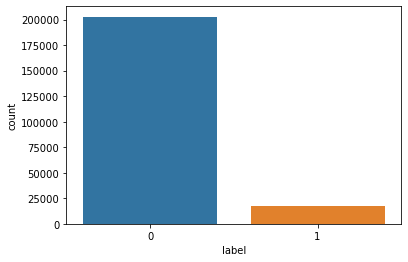

Imbalance: 0.07899996366147026


In [8]:
# positive class
sns.countplot(x=y)
plt.show()
print(f'Imbalance: {sum(y)/len(y)}')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=0.4, 
                                                    random_state=42
                                                   )

# Bench mark

## Count vectorizer

Creates a dictionary with the top 10000 words in the training corpus according to frequency. We use this to get a first benchmark after doing nothing to the data

In [13]:
vectorizer = CountVectorizer(max_features=10000, 
                             lowercase=True)
vectorizer.fit(X_train)

CountVectorizer(max_features=10000)

In [15]:
# here's a simple classifier, we can try different ones
lg = LogisticRegression()
lg.fit(vectorizer.transform(X_train).toarray(), y_train)
print(classification_report(y_test, lg.predict(vectorizer.transform(X_test))))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     81179
           1       0.22      0.02      0.03      6882

    accuracy                           0.92     88061
   macro avg       0.57      0.51      0.49     88061
weighted avg       0.87      0.92      0.89     88061



Very poor performance, mostly due to the imbalance of the classes

# Balancing the classes

## Down sampling

In [20]:
bots = df_en[df_en.label=='bot'].copy()
humans = df_en[df_en.label=='human'].sample(frac=0.0857).copy()
df_small = pd.concat([bots,humans]).reset_index().drop(columns='index')

In [24]:
df_clean = preproccesing.preprocessing(
                                        df=df_small,
                                        lowercase=False, 
                                        stopwords=False, 
                                        links=False, 
                                        tags=False, 
                                        numbers=False, 
                                        emojis=False, 
                                        hashtag=False,
                                        rt=False
                                       ).copy()

In [25]:
data=df_clean.copy()

In [26]:
X_balanced = data.text
y_balanced = data.label.map(lambda x: 1 if x=='bot' else 0)

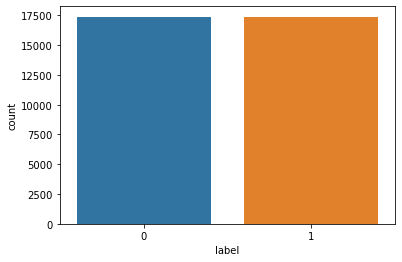

Imbalance: 0.5002157093963013


In [27]:
# positive class
sns.countplot(x=y_balanced)
plt.show()
print(f'Imbalance: {sum(y_balanced)/len(y_balanced)}')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    X_balanced, 
                                                    y_balanced, 
                                                    test_size=0.4, 
                                                    random_state=42
                                                   )

### Count vectorizer

Creates a dictionary with the top 10000 words in the training corpus according to frequency. We use this to get a first benchmark after doing nothing to the data

In [29]:
vectorizer = CountVectorizer(max_features=10000, 
                             lowercase=True)
vectorizer.fit(X_train)

CountVectorizer(max_features=10000)

In [31]:
# here's a simple classifier, we can try different ones
lg = LogisticRegression()
lg.fit(vectorizer.transform(X_train).toarray(), y_train)
print(classification_report(y_test, lg.predict(vectorizer.transform(X_test))))

              precision    recall  f1-score   support

           0       0.54      0.56      0.55      6947
           1       0.55      0.53      0.54      6961

    accuracy                           0.54     13908
   macro avg       0.54      0.54      0.54     13908
weighted avg       0.54      0.54      0.54     13908



We got rid of the overfitting, and now we have a very poor classifier. Let's try SMOTEEN balancing before trying different things to better our model

## SMOTEEN 

For memory reasons, we have to downsample a little bit

In [41]:
# downsampling a little bit

bots = df_en[df_en.label=='bot'].copy()
humans = df_en[df_en.label=='human'].sample(frac=0.3).copy()
df_small = pd.concat([bots,humans]).reset_index().drop(columns='index')

df_clean = preproccesing.preprocessing(
                                        df=df_small,
                                        lowercase=False, 
                                        stopwords=False, 
                                        links=False, 
                                        tags=False, 
                                        numbers=False, 
                                        emojis=False, 
                                        hashtag=False,
                                        rt=False
                                       ).copy()

data=df_clean.copy()

X = data.text
y = data.label.map(lambda x: 1 if x=='bot' else 0)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=0.4, 
                                                    random_state=42
                                                   )

vectorizer = CountVectorizer(max_features=10000, 
                             lowercase=True)
vectorizer.fit(X_train)

CountVectorizer(max_features=10000)

In [43]:
# smoteen
sme = SMOTEENN(random_state=42)
X_sme, y_sme = sme.fit_resample(vectorizer.transform(X_train).toarray(), y_train)

In [46]:
sum(y_train)/len(y_train)

0.22351487258160743

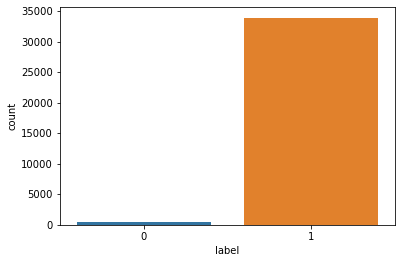

Imbalance: 0.9878752550276887


In [47]:
# positive class
sns.countplot(x=y_sme)
plt.show()
print(f'Imbalance: {sum(y_sme)/len(y_sme)}')

In [49]:
# here's a simple classifier, we can try different ones
lg = LogisticRegression()
lg.fit(X_sme, y_sme)
print(classification_report(y_test, lg.predict(vectorizer.transform(X_test))))

              precision    recall  f1-score   support

           0       0.83      0.01      0.02     24386
           1       0.22      0.99      0.36      6902

    accuracy                           0.23     31288
   macro avg       0.53      0.50      0.19     31288
weighted avg       0.70      0.23      0.10     31288



This is taking a lot of time and requires more work as right now is changing the imbalance of the classes (i.e. is not working). I'll move on for now and return to this later 

# Cleaning

We stick to the downsampled dataset and now measure the impact of cleanning on performance

In [50]:
bots = df_en[df_en.label=='bot'].copy()
humans = df_en[df_en.label=='human'].sample(frac=0.0857).copy()
df_small = pd.concat([bots,humans]).reset_index().drop(columns='index')

In [60]:
params = {'stopwords':False, 
          'links':False, 
          'tags':False, 
          'numbers':False, 
          'emojis':False, 
          'hashtag':False,
          'rt':False}

for p, v in zip(params.keys(), params.values()):
    args = params.copy()
    args[p] = not v
    df_clean = preproccesing.preprocessing(df=df_small, **args).copy()
    data=df_clean.copy()
    
    X_balanced = data.text
    y_balanced = data.label.map(lambda x: 1 if x=='bot' else 0)
    
    X_train, X_test, y_train, y_test = train_test_split(
                                                    X_balanced, 
                                                    y_balanced, 
                                                    test_size=0.4, 
                                                    random_state=42
                                                   )
    
    vectorizer = CountVectorizer(max_features=10000, 
                             lowercase=True)
    vectorizer.fit(X_train)
    
    # here's a simple classifier, we can try different ones
    lg = LogisticRegression()
    lg.fit(vectorizer.transform(X_train).toarray(), y_train)
    print(p, args[p])
    print(classification_report(y_test, lg.predict(vectorizer.transform(X_test))))
    print('\n')

stopwords True
              precision    recall  f1-score   support

           0       0.54      0.56      0.55      6947
           1       0.54      0.52      0.53      6961

    accuracy                           0.54     13908
   macro avg       0.54      0.54      0.54     13908
weighted avg       0.54      0.54      0.54     13908



links True
              precision    recall  f1-score   support

           0       0.54      0.55      0.54      6947
           1       0.54      0.52      0.53      6961

    accuracy                           0.54     13908
   macro avg       0.54      0.54      0.54     13908
weighted avg       0.54      0.54      0.54     13908



tags True
              precision    recall  f1-score   support

           0       0.54      0.56      0.55      6947
           1       0.54      0.52      0.53      6961

    accuracy                           0.54     13908
   macro avg       0.54      0.54      0.54     13908
weighted avg       0.54      0.54 

In [61]:
# effect of combined cleanning
params = {'stopwords':False, 
          'links':False, 
          'tags':False, 
          'numbers':False, 
          'emojis':False, 
          'hashtag':False,
          'rt':False}
args = params.copy()
for p, v in zip(params.keys(), params.values()):
    args[p] = not v

print(args)
df_clean = preproccesing.preprocessing(df=df_small, **args).copy()
data=df_clean.copy()


X_balanced = data.text
y_balanced = data.label.map(lambda x: 1 if x=='bot' else 0)


X_train, X_test, y_train, y_test = train_test_split(
                                        X_balanced, 
                                        y_balanced, 
                                        test_size=0.4, 
                                        random_state=42
                                    )


vectorizer = CountVectorizer(max_features=10000, 
                                lowercase=True)
vectorizer.fit(X_train)


# here's a simple classifier, we can try different ones
lg = LogisticRegression()
lg.fit(vectorizer.transform(X_train).toarray(), y_train)
print(classification_report(y_test, lg.predict(vectorizer.transform(X_test))))

{'stopwords': True, 'links': True, 'tags': True, 'numbers': True, 'emojis': True, 'hashtag': True, 'rt': True}
              precision    recall  f1-score   support

           0       0.53      0.52      0.53      6947
           1       0.53      0.54      0.54      6961

    accuracy                           0.53     13908
   macro avg       0.53      0.53      0.53     13908
weighted avg       0.53      0.53      0.53     13908





# Representations

So far, we have been able to improve our model's performance by downsampling the majority class. We also learnt that preprocessing, altghough useful, isn't going to radically change the classification performance. We have done this using the simplest of encoders (Count Vectorizer) and a very simple model (Logistic Regression).

Now that we know this approaches won't be enough, it's time to get more sophisticated. 

We'll start by using a better counting encoder: Tfidf Vectorizer. If we don't see enough improvement, we'll finally move to transformers. 

In [9]:
bots = df_en[df_en.label=='bot'].copy()
humans = df_en[df_en.label=='human'].sample(frac=0.3).copy()
df_small = pd.concat([bots,humans]).reset_index().drop(columns='index')
params = {'stopwords':False, 
          'links':False, 
          'tags':False, 
          'numbers':False, 
          'emojis':False, 
          'hashtag':False,
          'rt':False}
args = params.copy()
#for p, v in zip(params.keys(), params.values()):
#    args[p] = not v
df_clean = preproccesing.preprocessing(df=df_small, **args).copy()
data=df_clean.copy()
X_balanced = data.text
y_balanced = data.label.map(lambda x: 1 if x=='bot' else 0)
#X_train, X_test, y_train, y_test = train_test_split(
#                                        X_balanced, 
#                                        y_balanced, 
#                                        test_size=0.4, 
#                                        random_state=42
#                                    )

## Tfidf Vectorizer

In [4]:
vectorizer = TfidfVectorizer(max_features=10000)
vectorizer.fit(X_balanced)

TfidfVectorizer(max_features=10000)

In [64]:
# here's a simple classifier, we can try different ones
lg = LogisticRegression()
lg.fit(vectorizer.transform(X_train).toarray(), y_train)
print(classification_report(y_test, lg.predict(vectorizer.transform(X_test))))

              precision    recall  f1-score   support

           0       0.54      0.53      0.53      6947
           1       0.54      0.55      0.55      6961

    accuracy                           0.54     13908
   macro avg       0.54      0.54      0.54     13908
weighted avg       0.54      0.54      0.54     13908



Once again, no improvement. Let's go to the transformers

## Transformers

Note that we'll test first without cleaning and then with full cleaning. But before doing that, we'll stick with the top 10k most frequent words for memory reasons. To do that, we can use the Tfidf Vectorizer we just trained

In [10]:
del bots, humans, df_small, df_clean, data, X_balanced, y_balanced
gc.collect()

60

In [11]:
bots = df_en[df_en.label=='bot'].copy()
humans = df_en[df_en.label=='human'].sample(frac=0.2).copy()
df_small = pd.concat([bots,humans]).reset_index().drop(columns='index')
params = {'lower':False,
          'stopwords':False, 
          'links':False, 
          'tags':False, 
          'numbers':False, 
          'emojis':False, 
          'hashtag':False,
          'rt':False}
df_clean = preproccesing.preprocessing(df=df_small, **args).copy()
data=df_clean.copy()

X_balanced = data.text
y_balanced = data.label.map(lambda x: 1 if x=='bot' else 0)
X_train, X_test, y_train, y_test = train_test_split(
                                        X_balanced, 
                                        y_balanced, 
                                        test_size=0.4, 
                                        random_state=42
                                    )

In [14]:
def get_representation(data, 
                       model_name='distilbert-base-uncased', 
                       splits=30):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    tokens = tokenizer(list(data.values),
                   truncation=True, 
                   max_length=128,
                   return_tensors='pt', 
                   padding=True)
    
    ids = np.array_split(tokens.input_ids, splits)
    attentions = np.array_split(tokens.attention_mask, splits)
    emb_dim = model.config.dim
    representation = np.zeros((1,emb_dim))
    i = 0
    for batch_input, batch_attention in zip(ids, attentions):
        embd_batch = model(input_ids=batch_input,
                           attention_mask=batch_attention,
                           output_attentions=False, 
                           output_hidden_states=False)
        # tweet representation
        mean_emb_batch = torch.mean(embd_batch.last_hidden_state, axis=1)
        
        representation_batch = mean_emb_batch.detach().numpy()
        representation = np.concatenate((representation, representation_batch), axis=0)
        del embd_batch, mean_emb_batch, representation_batch
        gc.collect()
        i+=1
        print(f'Done {i}/{splits}')
    gc.collect() 
    return representation[1:,:]
        

In [15]:
X_train_emb = get_representation(data=X_train, 
                                 model_name='distilbert-base-uncased', 
                                 splits=50)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Done 1/50
Done 2/50
Done 3/50
Done 4/50
Done 5/50
Done 6/50
Done 7/50
Done 8/50
Done 9/50
Done 10/50
Done 11/50
Done 12/50
Done 13/50
Done 14/50
Done 15/50
Done 16/50
Done 17/50
Done 18/50
Done 19/50
Done 20/50
Done 21/50
Done 22/50
Done 23/50
Done 24/50
Done 25/50
Done 26/50
Done 27/50
Done 28/50
Done 29/50
Done 30/50
Done 31/50
Done 32/50
Done 33/50
Done 34/50
Done 35/50
Done 36/50
Done 37/50
Done 38/50
Done 39/50
Done 40/50
Done 41/50
Done 42/50
Done 43/50
Done 44/50
Done 45/50
Done 46/50
Done 47/50
Done 48/50
Done 49/50
Done 50/50


In [16]:
X_test_emb = get_representation(data=X_test, 
                                 model_name='distilbert-base-uncased', 
                                 splits=50)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Done 1/50
Done 2/50
Done 3/50
Done 4/50
Done 5/50
Done 6/50
Done 7/50
Done 8/50
Done 9/50
Done 10/50
Done 11/50
Done 12/50
Done 13/50
Done 14/50
Done 15/50
Done 16/50
Done 17/50
Done 18/50
Done 19/50
Done 20/50
Done 21/50
Done 22/50
Done 23/50
Done 24/50
Done 25/50
Done 26/50
Done 27/50
Done 28/50
Done 29/50
Done 30/50
Done 31/50
Done 32/50
Done 33/50
Done 34/50
Done 35/50
Done 36/50
Done 37/50
Done 38/50
Done 39/50
Done 40/50
Done 41/50
Done 42/50
Done 43/50
Done 44/50
Done 45/50
Done 46/50
Done 47/50
Done 48/50
Done 49/50
Done 50/50


In [9]:
for i, v in zip(X_train.index, X_train.values):
    X_train.loc[i] = ' '.join([i for i in v.split(' ') if i in vectorizer.vocabulary_])

In [10]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokens = tokenizer(list(X_train.values),
                   truncation=True, 
                   max_length=128,
                   return_tensors='pt', 
                   padding=True)

In [11]:
model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
resp = get_representation(tokens=tokens, 
                          model=model, 
                          splits=30)

Done 1/30
Done 2/30
Done 3/30
Done 4/30
Done 5/30
Done 6/30
Done 7/30
Done 8/30
Done 9/30
Done 10/30
Done 11/30
Done 12/30
Done 13/30
Done 14/30
Done 15/30
Done 16/30
Done 17/30
Done 18/30
Done 19/30
Done 20/30
Done 21/30
Done 22/30
Done 23/30
Done 24/30
Done 25/30
Done 26/30
Done 27/30
Done 28/30
Done 29/30
Done 30/30


In [17]:
lg = LogisticRegression()
lg.fit(X_train_emb, y_train)
print(classification_report(y_test, lg.predict(X_test_emb)))

              precision    recall  f1-score   support

           0       0.71      0.96      0.82     16176
           1       0.56      0.11      0.18      7002

    accuracy                           0.70     23178
   macro avg       0.64      0.54      0.50     23178
weighted avg       0.67      0.70      0.63     23178



In [18]:
xgb = XGBClassifier()
xgb.fit(X_train_emb, y_train)
print(classification_report(y_test, xgb.predict(X_test_emb)))

              precision    recall  f1-score   support

           0       0.72      0.91      0.80     16176
           1       0.44      0.17      0.24      7002

    accuracy                           0.68     23178
   macro avg       0.58      0.54      0.52     23178
weighted avg       0.63      0.68      0.63     23178



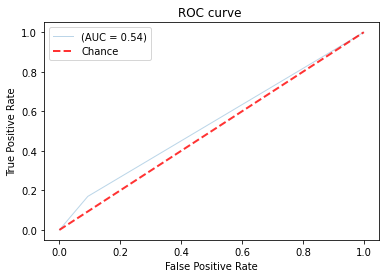

In [21]:
y_true = y_test
y_pre = xgb.predict(X_test_emb)
ax1=plt.subplot(111)
fpr, tpr, thresholds = roc_curve(y_true, y_pre)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, lw=1, alpha=0.3,label='(AUC = %0.2f)'%roc_auc)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC curve ')
ax1.legend(loc='best')
    

In [ ]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
model_name = 'distilbert-base-uncased'
result = []
splits = round(data.shape[0] / 100)
if splits > 1:
    j = 0
    for d_i in np.array_split(data, splits):
        representations = embeddings.get_representation(model_name, list(df_clean.text.values))
        result.append(representations.last_hidden_state)
        j += 1
        print(f'--- {j}/{splits} ---')
else:
    print('Nothing to do')

NameError: name 'model_name' is not defined

In [ ]:

representations = embeddings.get_representation(model_name, list(df_clean.text.values))